### SARIMAX model for time series prediction

In [96]:
# let's import necassary packages...

%pylab inline
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


/home/pk/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['sqrt', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


#### Loading Ethereum crypto coin data for prediction and forcasting

In [97]:
data = pd.read_csv('coin_Ethereum.csv', ',', index_col=['Date'], parse_dates=['Date'], dayfirst=True,encoding='cp1251')

In [98]:
data = data[['Close']]

In [99]:
data

,Close
Date,
2015-08-08 23:59:59,0.753325
2015-08-09 23:59:59,0.701897
2015-08-10 23:59:59,0.708448
2015-08-11 23:59:59,1.067860
2015-08-12 23:59:59,1.217440
...,...
2021-07-02 23:59:59,2150.040364
2021-07-03 23:59:59,2226.114282
2021-07-04 23:59:59,2321.724112


<Figure size 864x432 with 0 Axes>

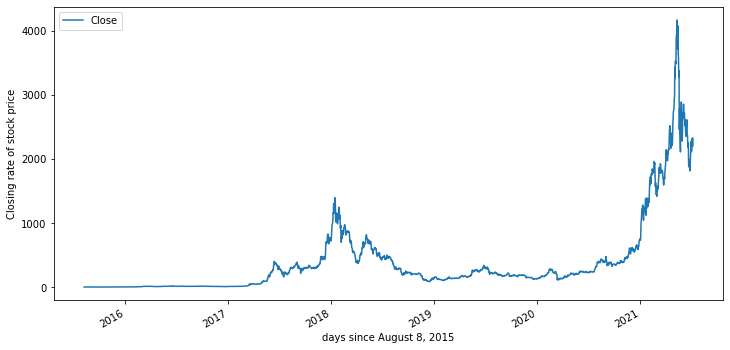

In [100]:
plt.figure(figsize(12,6))
data.plot()
plt.ylabel('Closing rate of stock price')
plt.xlabel('days since August 8, 2015')
pylab.show()

Dickey-Fuller test: p=0.956323


<Figure size 1080x720 with 0 Axes>

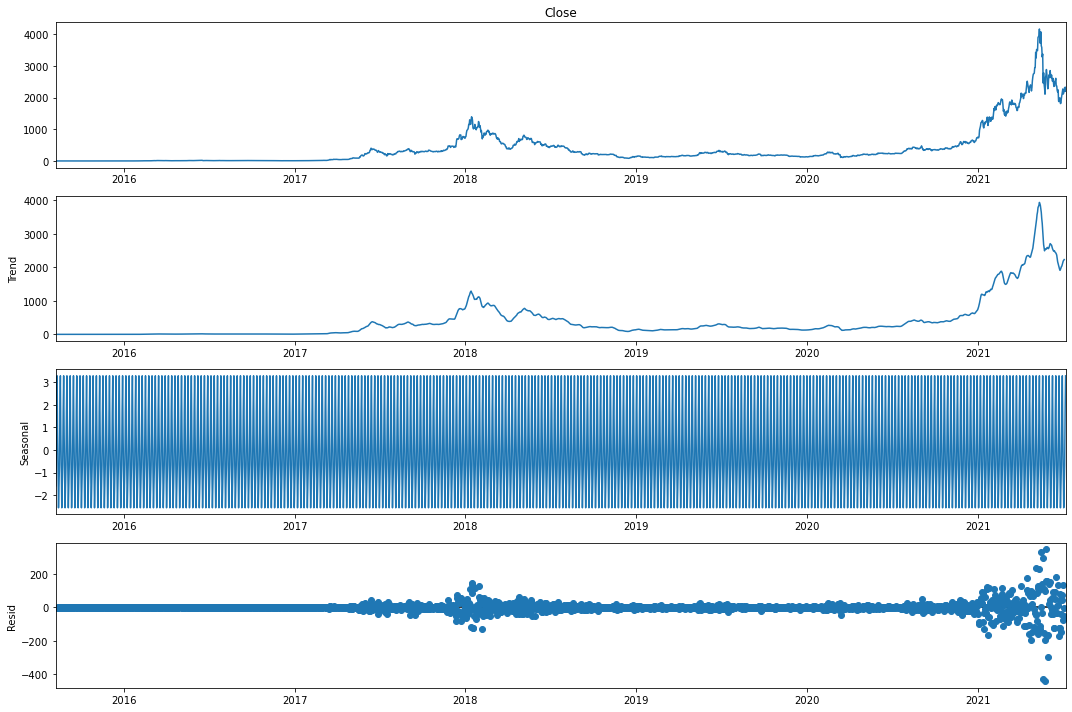

In [101]:
# evaluate components of time-series
# evaluate Dickey-Fuller test for time-series stationarity

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['Close']).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.Close)[1])

Best Box-Cox parameter: 0.185817
Dickey-Fuller test: p=0.956323


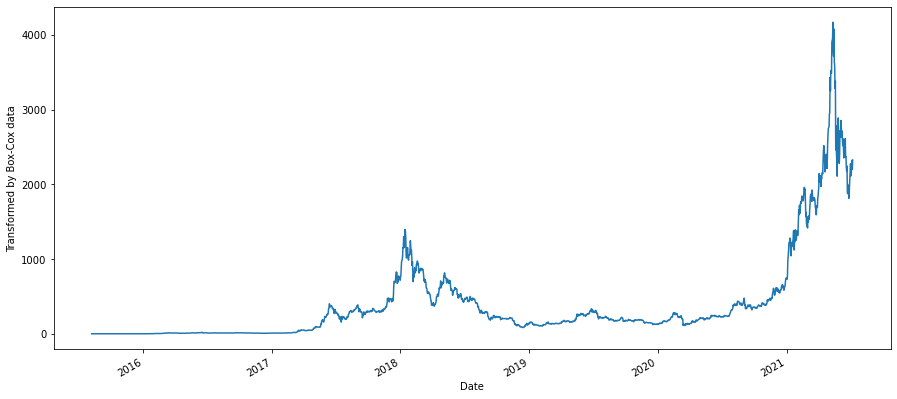

In [102]:
# Box-Cox transformation for dispersion stationarity

data['Close_box'], lmbda = stats.boxcox(data.Close)
plt.figure(figsize(15,7))
data.Close.plot()
plt.ylabel('Transformed by Box-Cox data')
print("Best Box-Cox parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.Close)[1])

Dickey-Fuller test: p=0.000000


<Figure size 1080x720 with 0 Axes>

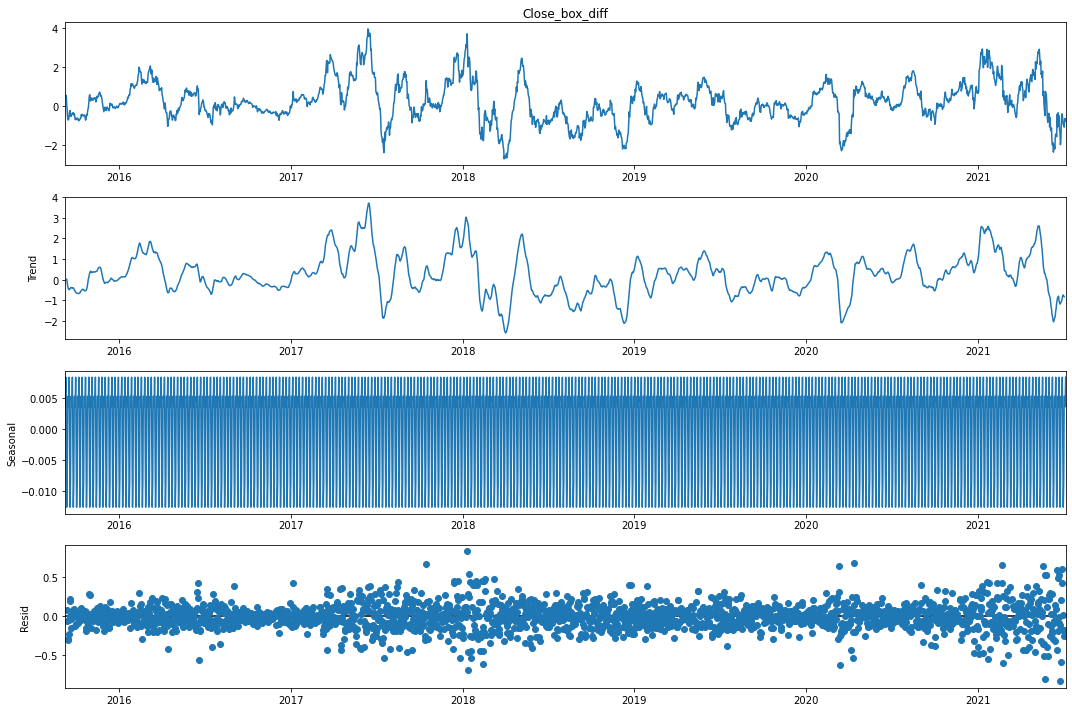

In [103]:
# seasonal difference for 12 months

data['Close_box_diff'] = data['Close_box'] - data['Close_box'].shift(30)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['Close_box_diff'][30:]).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data['Close_box_diff'][30:])[1])

In [104]:
data

,Close,Close_box,Close_box_diff
Date,,,
2015-08-08 23:59:59,0.753325,-0.275933,NaN
2015-08-09 23:59:59,0.701897,-0.342579,NaN
2015-08-10 23:59:59,0.708448,-0.333873,NaN
2015-08-11 23:59:59,1.067860,0.066059,NaN
2015-08-12 23:59:59,1.217440,0.200391,NaN
...,...,...,...
2021-07-02 23:59:59,2150.040364,17.012746,-0.977969
2021-07-03 23:59:59,2226.114282,17.157905,-1.066749
2021-07-04 23:59:59,2321.724112,17.334720,-0.627142


Dickey-Fuller test: p=0.000000000000006


<Figure size 1080x720 with 0 Axes>

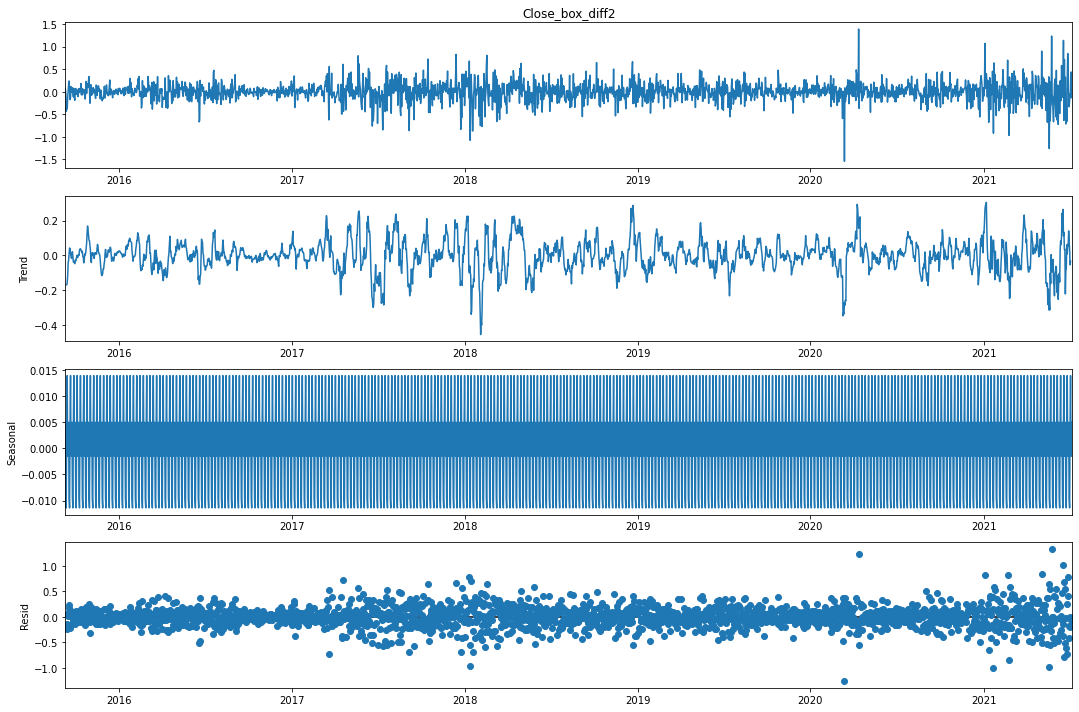

In [105]:
# additional 1-step difference

data['Close_box_diff2'] = data['Close_box_diff'] - data['Close_box_diff'].shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['Close_box_diff2'][31:]).plot()
print("Dickey-Fuller test: p=%.15f" % sm.tsa.stattools.adfuller(data['Close_box_diff2'][31:])[1])

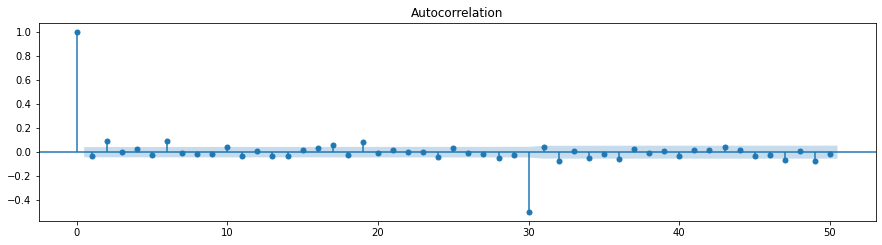

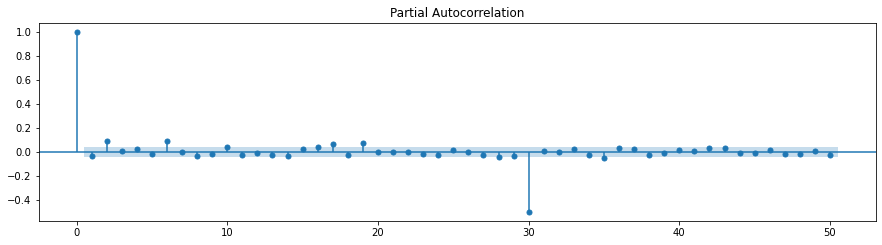

In [106]:
# let's calculate autocorrelation and partial autocorrelation components

plt.figure(figsize(15,8))

# autocorrelation 
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['Close_box_diff2'][31:].values.squeeze(), lags=50, ax=ax)
pylab.show()

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['Close_box_diff2'][31:].values.squeeze(), lags=50, ax=ax)
pylab.show()

In [110]:
# parameters for SARIMA model

ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 72


In [121]:
# parameters for SARIMA model

ps = range(4, 5)
d=1
qs = range(4, 5)
Ps = range(1, 3)
D=1
Qs= range(1,3)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 4


In [122]:
results = []
best_aic = float("inf")

# ignore warnings 
warnings.filterwarnings('ignore')

for param in parameters_list:
    
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(data['Close_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #print(aic)

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
        #print(results)
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())     

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

     parameters          aic
0  (4, 4, 1, 1) -1764.017456


In [123]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters          aic
0  (4, 4, 1, 1) -1764.017456


In [124]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            Close_box   No. Observations:                 2160
Model:             SARIMAX(4, 1, 4)x(1, 1, [1], 12)   Log Likelihood                 893.009
Date:                              Mon, 20 Dec 2021   AIC                          -1764.017
Time:                                      16:01:42   BIC                          -1701.627
Sample:                                  08-08-2015   HQIC                         -1741.191
                                       - 07-06-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4200      0.115     -3.642      0.000      -0.646      -0.194
ar.L2          0.01

Student test: p=0.936218
Dickey-Fuller test: p=0.0000000000000000000000000


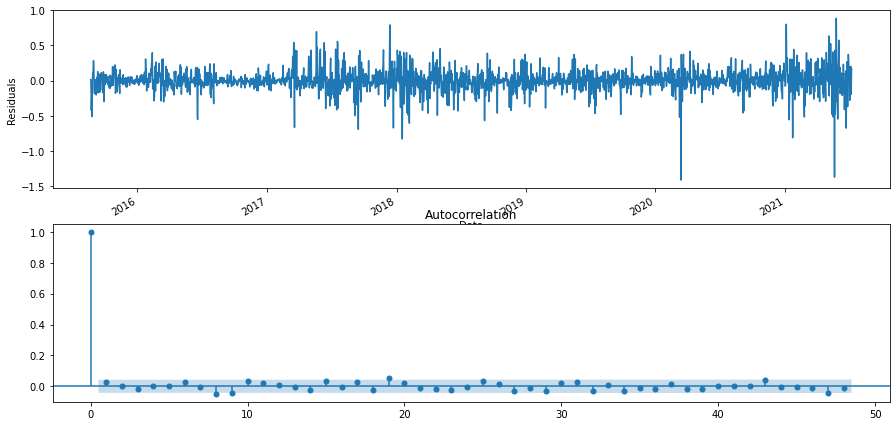

In [125]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[31:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[31:])[1])

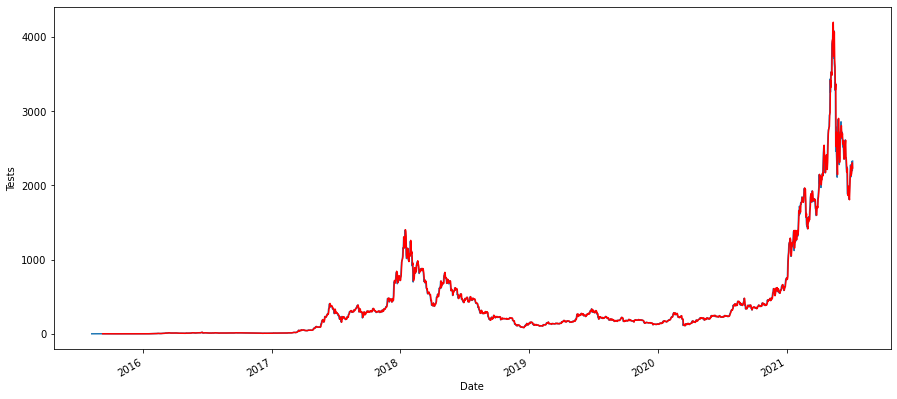

In [126]:
#inverse Box-Cox transformation:

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)
    
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data['Close'].plot()
data.model[31:].plot(color='r')
plt.ylabel('Tests')
pylab.show()



In [127]:
data

,Close,Close_box,Close_box_diff,Close_box_diff2,model
Date,,,,,
2015-08-08 23:59:59,0.753325,-0.275933,NaN,NaN,1.000000
2015-08-09 23:59:59,0.701897,-0.342579,NaN,NaN,0.753325
2015-08-10 23:59:59,0.708448,-0.333873,NaN,NaN,0.701897
2015-08-11 23:59:59,1.067860,0.066059,NaN,NaN,0.708448
2015-08-12 23:59:59,1.217440,0.200391,NaN,NaN,1.067860
...,...,...,...,...,...
2021-07-02 23:59:59,2150.040364,17.012746,-0.977969,-0.046809,2134.234466
2021-07-03 23:59:59,2226.114282,17.157905,-1.066749,-0.088780,2161.515746
2021-07-04 23:59:59,2321.724112,17.334720,-0.627142,0.439608,2213.708801


In [128]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [129]:
R2 = r2_score(data['Close'][int((4/5)*len(data)):], data['model'][int((4/5)*len(data)):])
MAPE = mean_absolute_percentage_error(data['Close'][int((4/5)*len(data)):], data['model'][int((4/5)*len(data)):])
print('MAPE:{} \n R2 score:{}'.format(MAPE, R2))


MAPE:0.037205200122190335 
 R2 score:0.989608697224514


#### MAPE and R2 metrics are 0.037 and 0.989 respectively

#### forcasting data for next 400 days

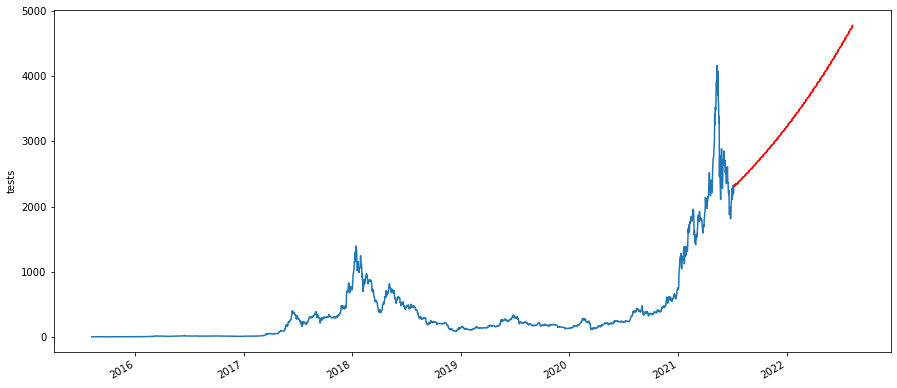

In [130]:
data2 = data[['Close']]
date_list = [datetime.datetime.strptime("2021-07-07 23:59:59", "%Y-%m-%d %H:%M:%S") + relativedelta(days=x) for x in range(0,400)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=2160, end=2560), lmbda)

plt.figure(figsize(15,7))
data2['Close'].plot()
data2.forecast.plot(color='r')
plt.ylabel('tests')
pylab.show()

### LSTM Model for time series prediction

In [93]:
# RNN - LSTM for time-series forecasting
# partly follows blog https://machinelearningmastery.com/introduction-to-time-series-forecasting-with-python/

from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
from numpy import array
 
# trajectory matrix for solving supervized learning task
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # output sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.fillna(0,inplace=True)
    return agg


# diffential series interval
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

 
# train / test splitting
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test


# fit an LSTM network
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    
    # stateful = True - keep state in memory;
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss=[]
    history_val_loss=[]
    for i in range(nb_epoch):
        print(i)
        hist = model.fit(X, y, validation_split=0.25,epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    print(model.summary())
    return model,history_loss,history_val_loss
 
# 1 step of forecasting
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]
 
# Forecasting
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_seq], test[i, n_seq:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
 
# inverse difference
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
 
# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted



<ipython-input-93-ab1a461b80ca>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [63]:
datal = pd.read_csv('coin_Ethereum.csv', ',', index_col=['Date'], parse_dates=['Date'], dayfirst=True,encoding='cp1251')

In [64]:
datal = datal[['Close']]

In [65]:
# trajectory matrix

d1 = series_to_supervised(datal, n_in=5, n_out=7, dropnan=True)
d1

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
Date,,,,,,,,,,,,
2015-08-08 23:59:59,0.000000,0.000000,0.000000,0.000000,0.000000,0.753325,0.701897,0.708448,1.067860,1.217440,1.82767,1.82787
2015-08-09 23:59:59,0.000000,0.000000,0.000000,0.000000,0.753325,0.701897,0.708448,1.067860,1.217440,1.827670,1.82787,1.68890
2015-08-10 23:59:59,0.000000,0.000000,0.000000,0.753325,0.701897,0.708448,1.067860,1.217440,1.827670,1.827870,1.68890,1.56603
2015-08-11 23:59:59,0.000000,0.000000,0.753325,0.701897,0.708448,1.067860,1.217440,1.827670,1.827870,1.688900,1.56603,1.20361
2015-08-12 23:59:59,0.000000,0.753325,0.701897,0.708448,1.067860,1.217440,1.827670,1.827870,1.688900,1.566030,1.20361,1.08705
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02 23:59:59,1978.894662,2079.657436,2160.768352,2274.547713,2113.605523,2150.040364,2226.114282,2321.724112,2198.582464,2324.679449,0.00000,0.00000
2021-07-03 23:59:59,2079.657436,2160.768352,2274.547713,2113.605523,2150.040364,2226.114282,2321.724112,2198.582464,2324.679449,0.000000,0.00000,0.00000
2021-07-04 23:59:59,2160.768352,2274.547713,2113.605523,2150.040364,2226.114282,2321.724112,2198.582464,2324.679449,0.000000,0.000000,0.00000,0.00000


In [75]:
# hyperparameters initialization and training the model

n_lag = 400
n_seq = 400
n_test = 400
n_epochs = 20
n_batch = 1
n_neurons =  8

scaler, train, test = prepare_data(datal, n_test, n_lag, n_seq)


In [94]:
model,history_loss,history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)


0
1319/1319 [==============================] - 4s 2ms/step - loss: 0.0026 - val_loss: 0.0032
1
1319/1319 [==============================] - 2s 2ms/step - loss: 9.8628e-04 - val_loss: 0.0032
2
1319/1319 [==============================] - 3s 2ms/step - loss: 9.7732e-04 - val_loss: 0.0032
3
1319/1319 [==============================] - 3s 2ms/step - loss: 9.6885e-04 - val_loss: 0.0032
4
1319/1319 [==============================] - 3s 2ms/step - loss: 9.6445e-04 - val_loss: 0.0032
5
1319/1319 [==============================] - 2s 2ms/step - loss: 9.6334e-04 - val_loss: 0.0032
6
1319/1319 [==============================] - 3s 2ms/step - loss: 9.7829e-04 - val_loss: 0.0033
7
1319/1319 [==============================] - 3s 2ms/step - loss: 9.8691e-04 - val_loss: 0.0032
8
1319/1319 [==============================] - 3s 2ms/step - loss: 9.7153e-04 - val_loss: 0.0032
9
1319/1319 [==============================] - 3s 2ms/step - loss: 9.7129e-04 - val_loss: 0.0032
10
1319/1319 [====================

In [77]:
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

forecasts = inverse_transform(datal, forecasts, scaler, n_test+2)

[0.0009576422744430602] [0.0032173222862184048]


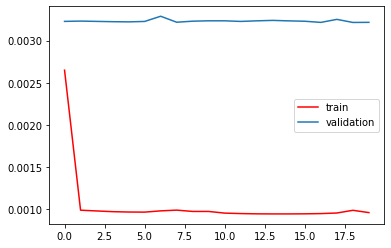

In [95]:
# Loss functions for val and train sets

plt.plot(history_loss, 'r',label='train')
plt.plot(history_val_loss,label='validation')
plt.legend()
print(history_loss[-1],history_val_loss[-1])

#### forcasting for next 400 days

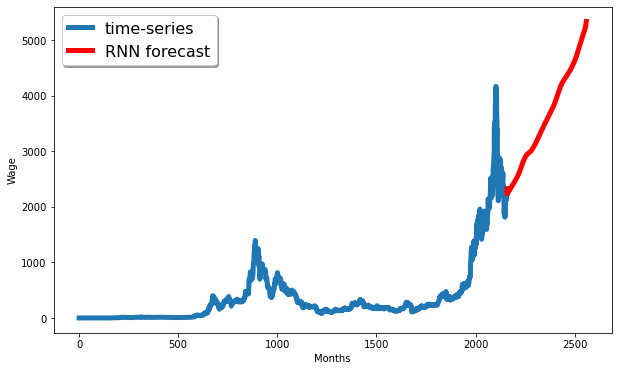

In [80]:
# visualize

fig=plt.figure(figsize=(10,6))
plt.plot(datal.values[:],linewidth=5)
off_s = len(datal) - n_test +len(forecasts)  - 1
off_e = off_s + len(forecasts) + 1
xaxis = [x for x in range(off_s, off_e)]
yaxis = [datal.values[off_s]] + forecasts[-1]
plt.plot(xaxis, yaxis, color='r',linewidth=5)

plt.ylabel('Wage')
plt.xlabel('Months')

plt.legend(('time-series', 'RNN forecast'),
           shadow=True, loc='upper left', handlelength=1.5, fontsize=16)
plt.show()


In [49]:

# walk-forward validation on the test data
predictions = list()
for i in range(len(test)):
    # make one-step forecast
    X, y = test[i, 0:-1], test[i, -1:]
    yhat = forecast_lstm(lstm_model,1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]



In [52]:
r2_score(datal.values[-400:], predictions)

0.9881839732887716

In [54]:
mean_absolute_percentage_error(datal[-400:], predictions)

0.038831244565287956

#### MAPE and R2 score for the LSTM model os 0.0388 and 0.988 respectivly

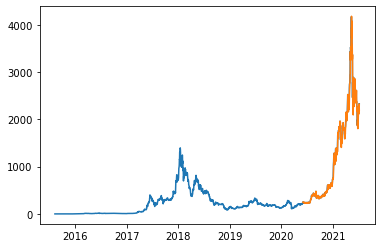

In [55]:
# report performance
rmse = sqrt(mean_squared_error(datal[-400:], predictions))
# line plot of observed vs predicted
plt.plot(series.index, datal[:])
plt.plot(series.index[-400:], predictions)
plt.show()

#### forecasts of two models on the single plot

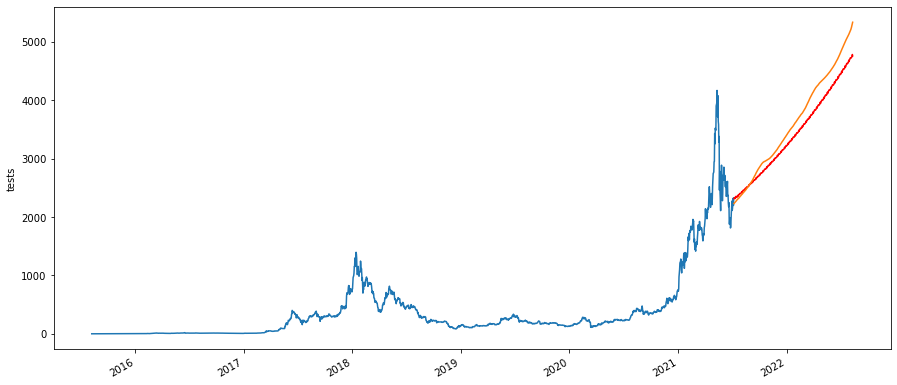

In [161]:
data2 = data[['Close']]
date_list = [datetime.datetime.strptime("2021-07-07 23:59:59", "%Y-%m-%d %H:%M:%S") + relativedelta(days=x) for x in range(0,400)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=2160, end=2560), lmbda)
# future_lstm = pd.DataFrame(index=date_list, columns= [i for i in yaxis])
data_lstm = pd.DataFrame({ 'Date': date_list, 'forcast_lstm': yaxis[1:] }) 

plt.figure(figsize(15,7))
data2['Close'].plot()
data2.forecast.plot(color='r')
plt.plot(data_lstm.Date, data_lstm.forcast_lstm)
# plt.plot(xaxis, yaxis, color='r',linewidth=5)
plt.ylabel('tests')
pylab.show()

#### Based on MAPE and R2 score SARIMAX model negligiblly slightly better than LSTM model, both models can be trained more by fne tuning the parameters.